# Data Preprocessing
We do it in python, because there is a much better support for stuff like multilingual bert models from huggingface.

In [4]:
import csv
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np


/home/benjamin/miniconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load pre-trained multilingual BERT model
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model = AutoModel.from_pretrained('bert-base-multilingual-cased')


## Load the dataset

In [6]:
input_filename = "src/data/settles.acl16.learning_traces.13m.csv"  # Change to the name of your input CSV file
output_filename = "src/data/language_small.csv"  # Change to the name you want for the output CSV file


In [7]:
dataset = ""

with open(input_filename, 'r') as csv_file:
    reader = csv.reader(csv_file)
    header = next(reader)  # Read the header
    dataset = [row for i, row in enumerate(reader) if i % 50 == 0]
    del header, reader


In [8]:
dataset

[['1.0',
  '1362076081',
  '27649635',
  'u:FO',
  'de',
  'en',
  '76390c1350a8dac31186187e2fe1e178',
  'lernt/lernen<vblex><pri><p3><sg>',
  '6',
  '4',
  '2',
  '2'],
 ['1.0',
  '1362082274',
  '7239420',
  'u:dDwF',
  'es',
  'en',
  '81fe07635e2aa79cd36709cf1bdd81be',
  'limón/limón<n><m><sg>',
  '3',
  '2',
  '2',
  '2'],
 ['1.0',
  '1362082511',
  '442233',
  'u:fxGh',
  'es',
  'en',
  '751cef71758f92e031ad696122464d2f',
  'gatos/gato<n><m><pl>',
  '8',
  '8',
  '1',
  '1'],
 ['1.0',
  '1362082527',
  '179',
  'u:h5ex',
  'de',
  'en',
  '9e1f56b08922d1d9f7ab663b58d88367',
  'freundin/freundin<n><f><sg><acc>',
  '4',
  '4',
  '2',
  '2'],
 ['1.0',
  '1362082533',
  '889',
  'u:ezFh',
  'es',
  'en',
  'ab724af62c7e36266ef3b66766d47489',
  'te/prpers<prn><pro><p2><mf><sg>',
  '260',
  '220',
  '1',
  '1'],
 ['1.0',
  '1362082530',
  '185734',
  'u:hiS4',
  'fr',
  'en',
  'b6307c1d68391608e9adf2079c0a3051',
  '<*sf>/poche<n><f><*numb>',
  '5',
  '3',
  '1',
  '1'],
 ['1.0',
  '1

In [9]:
vocabulary_lex = [column[7] for column in dataset]
vocabulary_lex

['lernt/lernen<vblex><pri><p3><sg>',
 'limón/limón<n><m><sg>',
 'gatos/gato<n><m><pl>',
 'freundin/freundin<n><f><sg><acc>',
 'te/prpers<prn><pro><p2><mf><sg>',
 '<*sf>/poche<n><f><*numb>',
 'yo/prpers<prn><tn><p1><mf><sg>',
 'are/be<vbser><pres>',
 'drink/drink<vblex><pres>',
 'his/his<det><pos><sp>',
 'soy/ser<vbser><pri><p1><sg>',
 'and/and<cnjcoo>',
 'for/for<pr>',
 'hombre/hombre<n><m><sg>',
 'open/open<vblex><inf><@future_phrasal>',
 'plate/plate<n><sg>',
 'we/prpers<prn><subj><p1><mf><pl>',
 'entered/enter<vblex><past>',
 'pájaros/pájaro<n><m><pl>',
 'cocino/cocinar<vblex><pri><p1><sg>',
 'fresa/fresa<n><f><sg>',
 'azules/azul<adj><mf><pl>',
 'cheese/cheese<n><sg>',
 'pescado/pescado<n><m><sg>',
 'nor/nor<cnjcoo>',
 'plays/play<vblex><pri><p3><sg>',
 'cavallo/cavallo<n><m><sg>',
 '<*sf>/untersuchung<n><f><*numb><*case>',
 'bebe/beber<vblex><pri><p3><sg>',
 'bevono/bere<vblex><pri><p3><pl>',
 'kind/kind<n><nt><sg><nom>',
 'camisa/camisa<n><f><sg>',
 'i/prpers<prn><subj><p1><mf><s

In [10]:
all_lex_tags = set()

for lex in vocabulary_lex:
    for l in lex.split("/")[-1].split("<")[1:]:
        all_lex_tags.add(l.replace(">", ""))
    
print(all_lex_tags)


{'vbdo', '@adv:por_supuesto', '@adv:en_fait', '@adv:a_part', 'pprep', '@cond', '@common_phrases:a_plus', 'subj', '@pr:afin_de', '@cnj:pendant_que', 'sint', 'p2', '@ij:bis_bald', 'pred', '@past_perfect', '*pers', 'vblex', '@cnj:du_fait_que', '@common_phrases:comment_ca_va', '@itg:est_ce_que', '@past_cond', '@adv:s_il_te_plait', '@prn:l_un', 'ifi', '*case', 'inf', 'ij', '@common_phrases:ca_va_bien', '@det:a_le', '@adv:au_dela', '@future', 'pr+el', '@cnj:alors_que', 'attr', 'prn', 'pii', '@cnj:autant_que', '@cnj:depuis_que', 'pri', '@past_subjunctive', '@neg:plus_de', '@adv:a_peu_pres', '@adv:peut_etre', '@ij:merci_beaucoup', '@pr:au_dela_de', '@prn:celui_la', 'cnjadv', 'dat', 'loc', 'pr', '@pluperfect', 'pro', '@pr:a_cote_de', '@neg:pas_du_tout', 'nn', 'sg', 'dem', 'n+sandwich', '@ger_past', 'num', '*gndr', 'past', '@cnj:parce_que', '@cnj:tandis_que', 'm', '@adv:tout_a_fait', 'vblex+ort', 'nom', 'n', 'def', 'pst', 'mix', '@prn:quelque_chose', '@det:de_le', 'pron', 'apos', 'ger', '@prn:qu

## Let's do the Bert Embeddings

In [11]:
pattern = r'([^<]+/\w+)<'

vocabulary = set()
for i in [re.match(pattern, s).group(1) for s in vocabulary_lex if re.match(pattern, s)]:
    words = i.split("/")
    vocabulary.add(words[0])
    vocabulary.add(words[1])
vocabulary= list(vocabulary)
len(vocabulary)

6639

In [12]:
def get_embeddings_iteratively(phrases, batch_size=2, output_file='embeddings.npy'):
    all_embeddings = []
    for i in range(0, len(phrases), batch_size):
        batch = phrases[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True)
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling
        embeddings = embeddings.detach().numpy()
        all_embeddings.append(embeddings)
        del inputs, outputs, embeddings
        torch.cuda.empty_cache()  # Clear GPU memory if using GPU
    all_embeddings = np.vstack(all_embeddings)
    np.save(output_file, all_embeddings)
    return all_embeddings


In [13]:
embeddings = get_embeddings_iteratively(vocabulary, batch_size=1000, output_file='embeddings.npy')


In [16]:
embeddings = np.load('embeddings.npy')
embeddings.shape

(6639, 768)

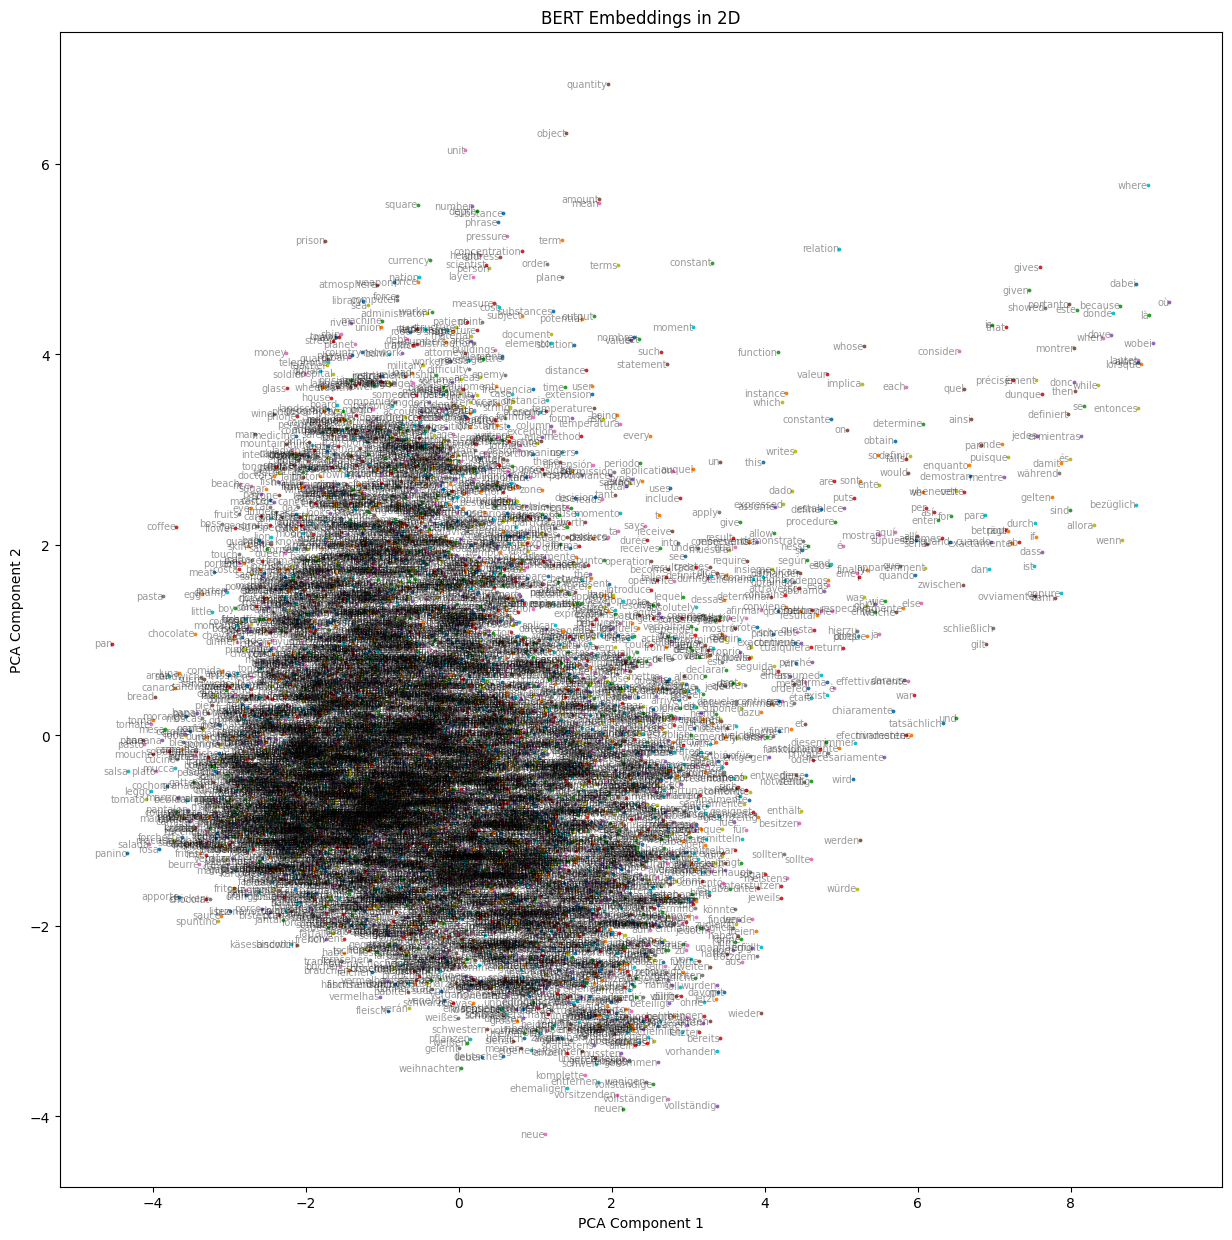

In [19]:
# Reduce dimensionality of embeddings
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(15, 15))
for i, phrase in enumerate(vocabulary):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=phrase, s=3)
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], phrase, fontsize=7, alpha=0.4, ha='right', va='center')
plt.title("BERT Embeddings in 2D")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()



In [ ]:
# with open(output_file, 'w', newline='') as csv_file:
#     writer = csv.writer(csv_file)
#     writer.writerow(header)  # Write the header
#     writer.writerows(data)   # Write the filtered data
